Aim: to compare readings from HR strap from Garmin strap vs optical HR from Garmin Forerunner 35

In [28]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xml.etree.ElementTree as ET
import datetime

In [29]:
%matplotlib inline

In [30]:
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['font.size'] = 14

In [33]:
def trackpoint_to_dict(tp):
    """Save interesting info from Trackpoint element as dict"""
    return {
        'time': tp.find('g:Time', ns).text,
        'hr': int(tp.find('g:HeartRateBpm/g:Value', ns).text)
    }

In [109]:
def tcx_to_dataframe(tcx_filename):
    """Open TCX file, pull info for each trackpoint in time.
    Returns info as pandas Dataframe
    """
    tree = ET.parse(tcx_filename)
    root = tree.getroot()
    ns = {"g": "http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2"}  # garmin namespace, bleurgh
    trackpoints = root.findall(".//g:Trackpoint", ns)
    dicts = [trackpoint_to_dict(tp) for tp in trackpoints] 
    df = pd.DataFrame(dicts)
    df.index = pd.to_datetime(df['time'])
    df = df.drop(['time'], axis=1)
    df = df.resample('1S').mean()  # resample to align to exact seconds for easier comparison
    return df

In [110]:
df_strap = tcx_to_dataframe("strap.tcx")

In [111]:
df_watch = tcx_to_dataframe("watch.tcx")

In [112]:
# Convert to time from start of activity
start_time = min(df_strap.index[0], df_watch.index[0])
df_watch['rel_time'] = df_watch.index - start_time
df_strap['rel_time'] = df_strap.index - start_time

In [113]:
df_strap.dtypes

hr                    int64
rel_time    timedelta64[ns]
dtype: object

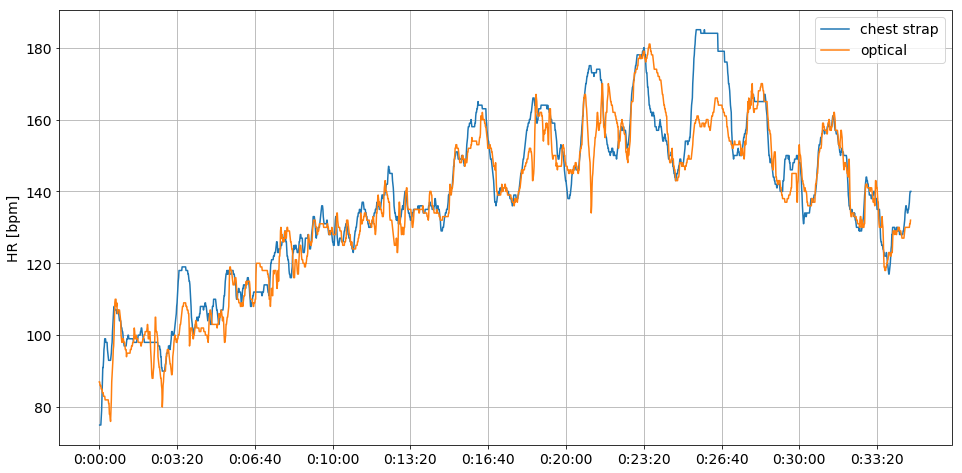

In [216]:
plt.plot(df_strap.rel_time, df_strap.hr, label='chest strap');
ax = plt.gca()
ax.plot(df_watch.rel_time, df_watch.hr, label='optical');
plt.legend(loc='best');
plt.ylabel('HR [bpm]');

ml = ax.xaxis.get_major_locator()
ml.set_params(nbins=20, min_n_ticks=10)
ax.xaxis.set_major_locator(ml)

# This doesn't work for timedelta, no idea why
# locator = mdates.AutoDateLocator()
# ax.xaxis.set_major_locator(locator)

def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(seconds=x/1E9)                                                                                                                                                                                                                                          
    return str(d)                                                                                                                                                                                                                                                              
formatter = mpl.ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
ax.xaxis.set_major_formatter(formatter)  

plt.grid()

Some interesting stuff:

- For the first ~15 minutes they track similarly.
- Note that the optical monitor failed to pickup the short effort at 3:20
- Once I hit the 30s intervals, things get worse. On some intervals the optical monitor is fine (e.g. first and last few), but at other times it reads significantly lower (>20BPM at times), and in one case ~23:30 it reads higher.
- For the intervals where it agrees with the chest strap, it shows that it is able to capture the rapid rise & fall of my HR
- The effort at ~26 min was definitely the hardest, which the cheststrap shows but the optical monitor fails to mirror.

In [115]:
df_watch.head()

,hr,rel_time
time,,
2018-01-06 18:52:41,87,00:00:00
2018-01-06 18:52:42,87,00:00:01
2018-01-06 18:52:43,86,00:00:02
2018-01-06 18:52:44,86,00:00:03
2018-01-06 18:52:45,86,00:00:04


In [116]:
df_strap.head()

,hr,rel_time
time,,
2018-01-06 18:52:42,75,00:00:01
2018-01-06 18:52:43,75,00:00:02
2018-01-06 18:52:44,75,00:00:03
2018-01-06 18:52:45,75,00:00:04
2018-01-06 18:52:46,77,00:00:05


Let's plot difference in HR at each second to directly compare (requires the resampling bit above)

In [213]:
diff = (df_watch - df_strap).dropna().drop(['rel_time'], axis=1)

In [214]:
# Get standard quantiles (95%, 68%, 50%)
quantiles = diff.hr.quantile([0.025, 0.16, 0.25, 0.5, 0.75, 0.84, 0.975])
print(quantiles)

0.025   -24.0
0.160    -8.0
0.250    -5.0
0.500    -1.0
0.750     1.0
0.840     3.0
0.975    12.0
Name: hr, dtype: float64


So 50% of readings are within 6 BPM, 68% are within 11 BPM, and 95% are within 36 BPM (!). It is interesting to note that, on the whole, the optical sensor reads slightly lower than the strap - however this includes the big deviations at hard intervals. We can try and exclude such hard efforts to see if they align a bit better.

In [204]:
mask = df_strap.hr < 140
diff_filtered = (df_watch - df_strap).drop(['rel_time'], axis=1).dropna()

In [205]:
mask.shape

(2087,)

In [206]:
diff_filtered.shape

(2086, 1)

In [210]:
diff_filtered = diff_filtered[mask]
diff_filtered = diff_filtered.dropna()
quantiles_filtered = diff_filtered.hr.quantile([0.025, 0.16, 0.25, 0.5, 0.75, 0.84, 0.975])
print(quantiles_filtered)

0.025   -14.0
0.160    -6.0
0.250    -4.0
0.500    -1.0
0.750     1.0
0.840     3.0
0.975     8.0
Name: hr, dtype: float64


/Users/robin/.virtualenvs/DataSciPy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


As expected, the median is unaffected, the 68% interval is slightly smaller (9 instead of 11 BPM), and the 95% one is now 22 BPM instead of 36 BPM.

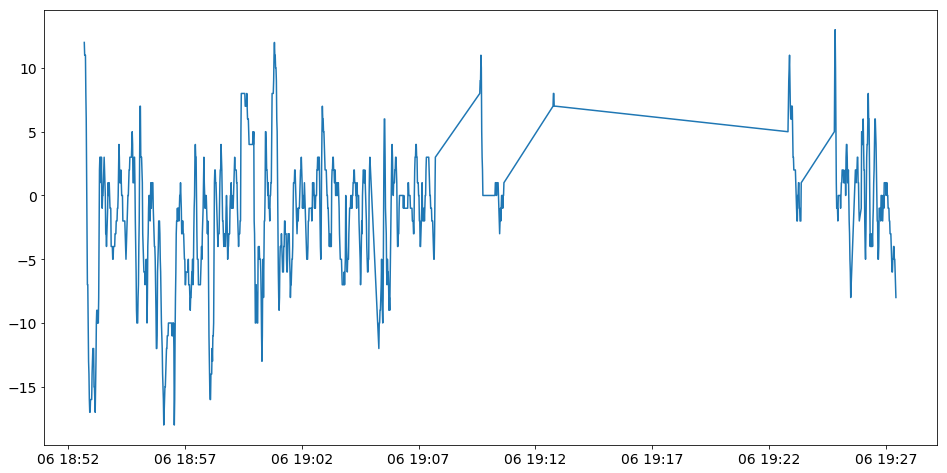

In [209]:
plt.plot(diff_filtered)

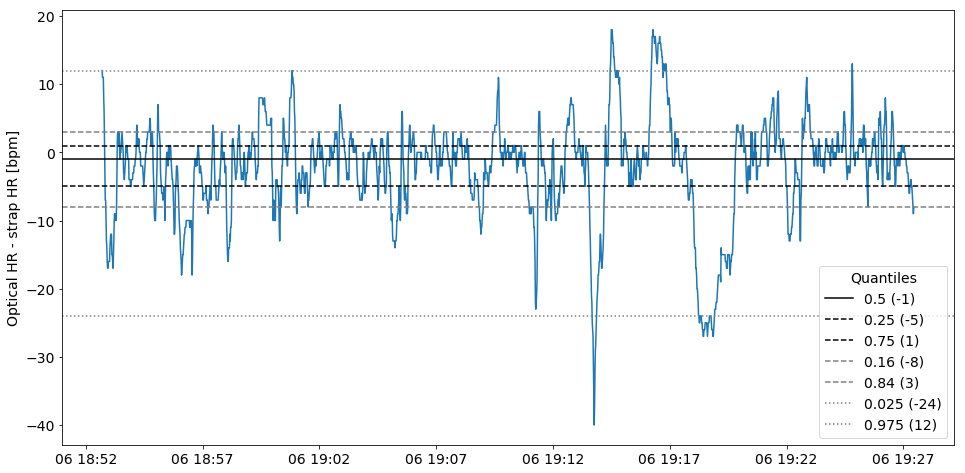

In [217]:
# with quantiles
plt.plot(diff);
plt.ylabel('Optical HR - strap HR [bpm]');
plt.axhline(quantiles[0.5], linestyle='solid', color='black', label='0.5 (%d)' % quantiles[0.5])
plt.axhline(quantiles[0.25], linestyle='dashed', color='black', label='0.25 (%d)' % quantiles[0.25])
plt.axhline(quantiles[0.75], linestyle='dashed', color='black', label='0.75 (%d)' % quantiles[0.75])
plt.axhline(quantiles[0.16], linestyle='dashed', color='grey', label='0.16 (%d)' % quantiles[0.16])
plt.axhline(quantiles[0.84], linestyle='dashed', color='grey', label='0.84 (%d)' % quantiles[0.84])
plt.axhline(quantiles[0.025], linestyle='dotted', color='grey', label='0.025 (%d)' % quantiles[0.025])
plt.axhline(quantiles[0.975], linestyle='dotted', color='grey', label='0.975 (%d)' % quantiles[0.975])
plt.legend(title="Quantiles");
# plt.grid();

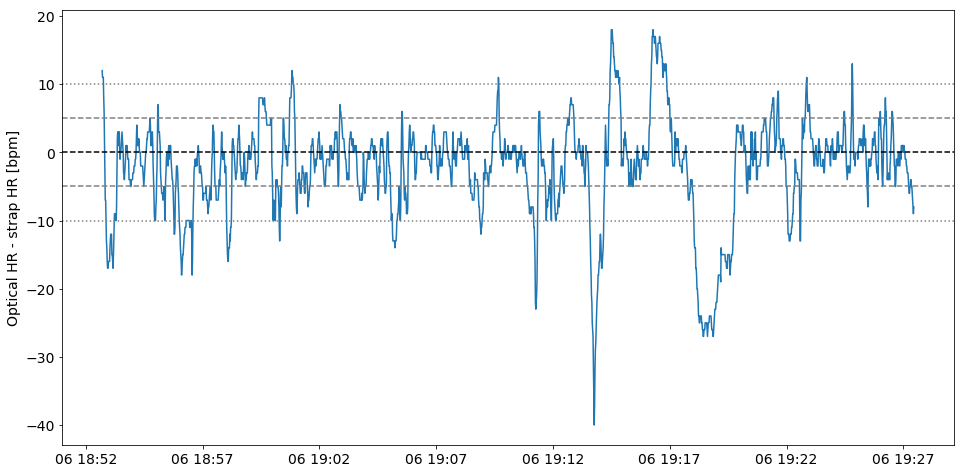

In [218]:
# with fixed reasonable horizontal lines (±5, ±10 bpm)
plt.plot(diff);
plt.ylabel('Optical HR - strap HR [bpm]');
plt.axhline(0, linestyle='dashed', color='black')
plt.axhline(-5, linestyle='dashed', color='grey')
plt.axhline(5, linestyle='dashed', color='grey')
plt.axhline(-10, linestyle='dotted', color='grey')
plt.axhline(10, linestyle='dotted', color='grey')

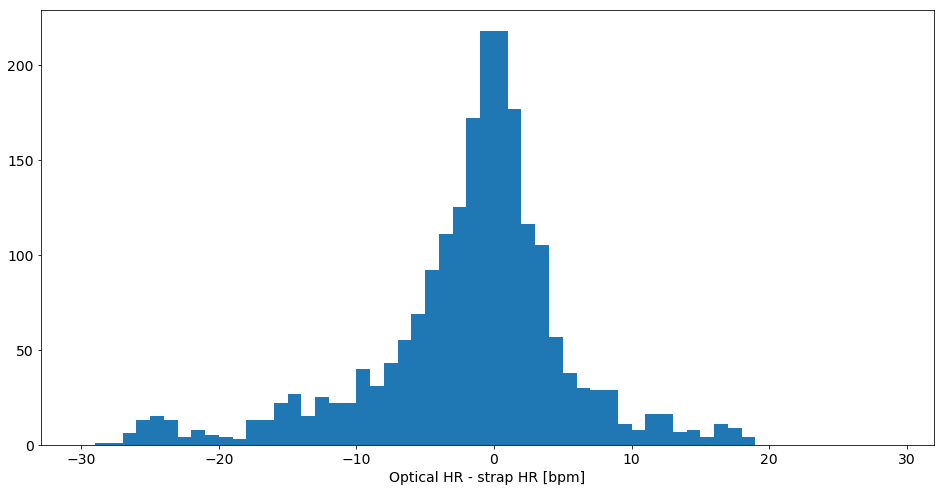

In [219]:
plt.hist(diff.hr, bins=np.arange(-30, 30, 1));
plt.xlabel('Optical HR - strap HR [bpm]');

Now repeat but scale by absolute HR (from chest strap)

In [169]:
rel_diff = ((df_watch.hr - df_strap.hr)/df_strap.hr).dropna()
rel_diff.head()

time
2018-01-06 18:52:42    0.160000
2018-01-06 18:52:43    0.146667
2018-01-06 18:52:44    0.146667
2018-01-06 18:52:45    0.146667
2018-01-06 18:52:46    0.103896
Freq: S, Name: hr, dtype: float64

In [179]:
# Get standard quantiles (95%, 68%, 50%)
quantiles = rel_diff.quantile([0.025, 0.16, 0.25, 0.5, 0.75, 0.84, 0.975])
print(quantiles)

0.025   -0.135870
0.160   -0.060811
0.250   -0.038186
0.500   -0.007576
0.750    0.009174
0.840    0.021645
0.975    0.082087
Name: hr, dtype: float64


So again, 50% of readings are within 4.7% of the strap value, 68% are within 8.2%, and 95% are within 22%.

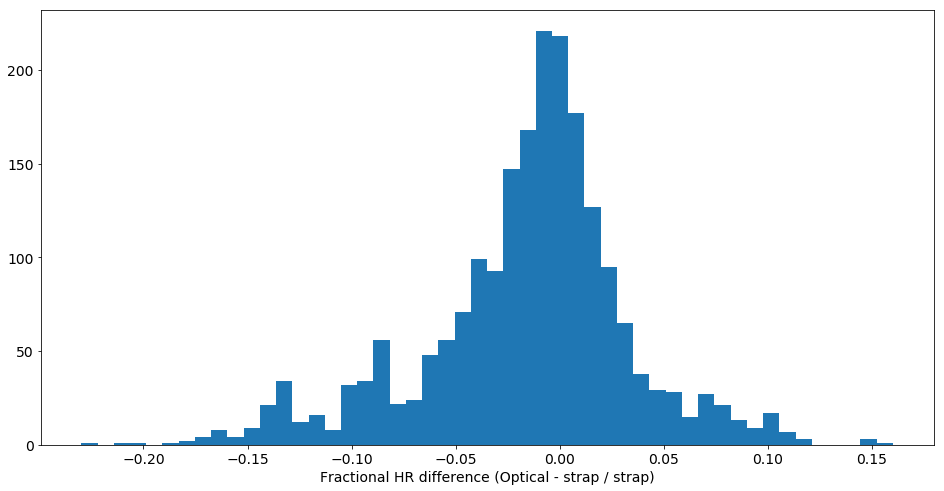

In [220]:
plt.hist(rel_diff, bins=50);
plt.xlabel('Fractional HR difference (Optical - strap / strap)');

Note: a better way to quantify accuracy would probably be to repeat the quantile measurements, grouped in bins of chest strap HR (i.e. get a precision/accuracy as a function of HR). This requires lots more data though to not be statistically limited. e.g. the distribution of HRs from the strap in this session is:

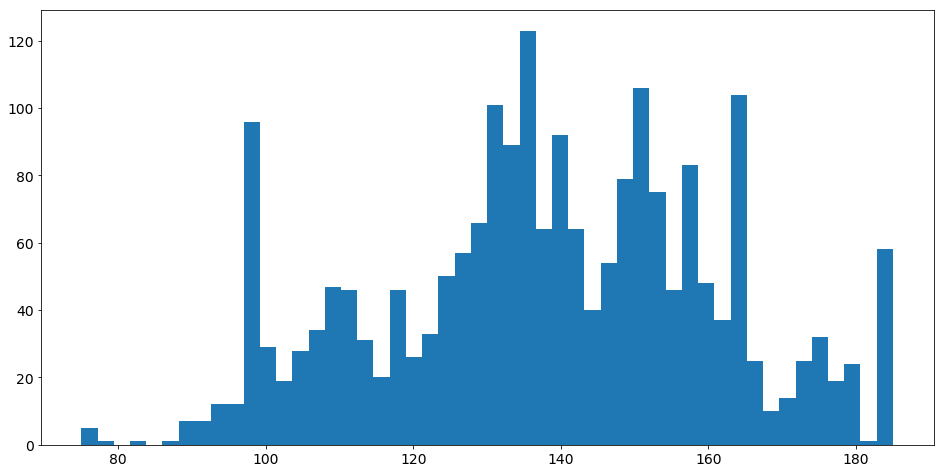

In [225]:
plt.hist(df_strap.hr, bins=50);

Can see some clear spikes (why the one at just below 100??)